### Banking Discipline and Elasticity
J M Applegate  
##### CAS543 Complexity Economics
The notebook presents basic banking discipline and elasticity dynamics.  
A set of $n$ of retail customers are served by $N$ banks.  
Banks hold reserves as a central bank according to a specified reserve requirement.  
Customer transactions take place every day, and every night the reserve accounts need to be non-negative.  
Surplus banks lend to deficit banks as requested to meet the overnight non-negative reserve requirement.  

In [22]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
plt.rc('font',**{'family':'sans-serif','sans-serif':['Futura']})
rng = np.random.default_rng()

In [23]:
# set parameters
n = 1000 # number of retail customers
N = 10 # number of banks
steps = 100 # number of simulation runs
tau = 200 # parameter for poisson function, mean number of transactions a step
reserve_reqmt = .5 # percentage of initial retail deposits as reserves
cb_rate = .2 # central bank lending rate
premium_basis = .01 # basis for risk premium
broker_network_fraction = .5 # fraction of banks that can be "reached" by a broker
max_balance = 100 # upper limit for initial retail deposits

In [24]:
# define utility function

# New!
def get_lender_quote(lender, borrower, reserves, net_positions, risk_appetites, cb_rate):
    # get_lender_quote simulates a agent shopping for quotes for overnight loans
    # thus giving us a pricing mechanism based on risk preferences
    if reserves[lender] > abs(reserves[borrower]): # only lend if capable
        risk_premium = max(0, -net_positions[borrower]) * premium_basis
        quote = cb_rate + risk_premium - risk_appetites[lender]
        return (quote, True)
    return (None, False) # if not capable donʻt quote


# define model functions

# New!
def update_net_positions(N, loans, reserves, customers, banks, balances, reserve_reqmt):
    # For all of our banks, we want to calculate how well they are keeping up with the reserve requirement
    # This is sort of a proxy for bank health in light of the fact that
    # loans in the model are simulated rather than operational.
    # Note that this could also be calculated on the spot from reserves and loans, but
    # that would be a pain in the neck. Also, maybe we would want to get more clever about
    # bank health in the future.
    
    # Initialize net positions list
    net_positions = []
    
    # Calculate required reserves for each bank
    for B in range(N):
        # Sum deposits for this bank
        bank_deposits = sum(balances[c] for c in range(len(customers)) if banks[c] == B)
        required_reserves = bank_deposits * reserve_reqmt
        
        # Calculate net position relative to requirement
        net_position = reserves[B] + sum(loans[B]) - required_reserves
        net_positions.append(net_position)
        
    return net_positions

# Existing!
# create reserves from retail deposit amounts
def create_reserves(N, customers, banks, balances, reserve_reqmt):
    deposits = []
    for B in range(N):
        bank_deposits = 0
        for c in customers:
            if banks[c] == B:
                bank_deposits += balances[c]
        deposits.append(bank_deposits)
    reserves = [reserve_reqmt * d for d in deposits]
    return(reserves)

# retail customers conduct transactions which are settled through aggregated central bank reserve transfers
def retail_transactions(tau, customers, banks, balances, reserves):
    transfers = rng.poisson(tau)
    originators = random.choices(customers, weights = balances, k=transfers) # originators weighted on bank balances
    #originators = random.choices(customers, k=transfers) #unwe
    percentages = rng.random(transfers).tolist()
    recipients = []
    for o in originators:
        others = [c for c in customers if c != o]
        other_balances = [b for i, b in enumerate(balances) if i != o] 
        recipient = random.choices(others, weights = other_balances)[0] # recipients weighted on bank balances
        #recipient = random.choices(others)[0]
        recipients.append(recipient)
    originating_banks = [banks[o] for o in originators]
    receiving_banks = [banks[r] for r in recipients]
    for t in range(transfers):
        amount = percentages[t] * balances[originators[t]]
        balances[recipients[t]] += amount
        balances[originators[t]] -= amount
        reserves[receiving_banks[t]] += amount
        reserves[originating_banks[t]] -= amount
    return(balances, reserves)

# surplus banks lend to deficit banks at the end of the day to ensure all reserve accounts are non-negative
def settle_deficits(N, reserves, loans, lenders, net_positions, risk_appetites):
    deficit_banks = [i for i, b in enumerate(reserves) if b < 0]
    possible_lenders = [x for x in range(N) if x not in deficit_banks]
    random.shuffle(possible_lenders)

    # in order to settle deficits, we need to get quotes from lenders
    # we simulate using a broker with "limited reach" to other banks
    # the broker will then choose the lowest quote and lend to the borrower

    broker_reach = int(N * broker_network_fraction) # we could have just said "5" but hey N can change!

    for i in deficit_banks:
        if len(possible_lenders) >= broker_reach:
            selected_lenders = random.sample(possible_lenders, broker_reach)
        else:
            selected_lenders = possible_lenders
            
        # Get quotes from each selected lender
        quotes = []
        for lender in selected_lenders:
            quote, can_lend = get_lender_quote(
                lender, i, reserves, net_positions, 
                risk_appetites, cb_rate
            )
            if can_lend:
                quotes.append((lender, quote))
    
        # order the quotes by the quote amount
        if quotes:
            lowest_quotes_first = sorted(quotes, key=lambda x: x[1])
            j = 0
            while reserves[i] < 0 and j < len(lowest_quotes_first):
                lender = lowest_quotes_first[j][0] # the lender id
                if reserves[lender] >= abs(reserves[i]):
                    reserves[lender] += reserves[i]
                    loans[i].append(abs(reserves[i]))
                    lenders[i].append(lender)
                    reserves[i] = 0
                elif reserves[lender] > 0:
                    loans[i].append(reserves[lender])
                    lenders[i].append(lender)
                    reserves[i] += reserves[lender]
                    reserves[lender] = 0
                    j += 1
                else:
                    j += 1
    return(reserves, loans, lenders)

# borrowing banks repay overnight loans
def repay_loans(N, loans, lenders, reserves):
    for B in range(N):
        for l in loans[B]:
            reserves[lenders[B][0]] += l * (1 + cb_rate)
            reserves[B] -= l * (1 + cb_rate)
            loans[B].pop(0)
            lenders[B].pop(0)
    return(loans, lenders, reserves)

In [25]:
# initialise data structures
customers = list(range(n))
banks = rng.choice(range(N), n).tolist()
balances = rng.uniform(1, max_balance, n).tolist()
loans = [[] for _ in range(N)]
lenders = [[] for _ in range(N)]
customer_history = pd.DataFrame()
bank_history = pd.DataFrame()

# calculate reserves based on retail deposits
reserves = create_reserves(N, customers, banks, balances, reserve_reqmt)

# we should now be able to initialize our asset positions
net_positions = update_net_positions(N, loans, reserves, customers, banks, balances, reserve_reqmt)

# and our risk appetites are simple enough...
risk_appetites = rng.normal(0, 1, N).tolist()

# populate history arrays with initial values
customer_history['step'] = [0] * n
customer_history['id'] = customers
customer_history['balance'] = balances
bank_history['step'] = [0] * N
bank_history['id'] = list(range(N))
bank_history['reserves'] = reserves
bank_history['loans'] = [sum(l0) for l0 in loans]
bank_history['net_positions'] = net_positions
bank_history['risk_appetite'] = risk_appetites

for s in range(1, steps+1):
    
    #repay overnight loans
    loans, lenders, reserves = repay_loans(N, loans, lenders, reserves)
            
    #conduct retail customer activity
    balances, reserves = retail_transactions(tau, customers, banks, balances, reserves)

    #settle negative reserve accounts at end of day
    reserves, loans, lenders = settle_deficits(N, reserves, loans, lenders, net_positions, risk_appetites)

    #and finally update our net_positions
    net_positions = update_net_positions(N, loans, reserves, customers, banks, balances, reserve_reqmt)

    # store simulation values as dataframes
    customer_step = pd.DataFrame()
    bank_step = pd.DataFrame()

    customer_step['step'] = [s] * n
    customer_step['id'] = customers
    customer_step['balance'] = balances

    bank_step['step'] = [s] * N
    bank_step['id'] = list(range(N))
    bank_step['reserves'] = reserves
    bank_step['loans'] = [sum(l1) for l1 in loans]

    customer_history = pd.concat([customer_history, customer_step], ignore_index=True)
    bank_history = pd.concat([bank_history, bank_step], ignore_index=True)

The first set of simulation result plots show  
1) retail deposit account balances for each customer over time
2) reserve account balances for each bank over time.

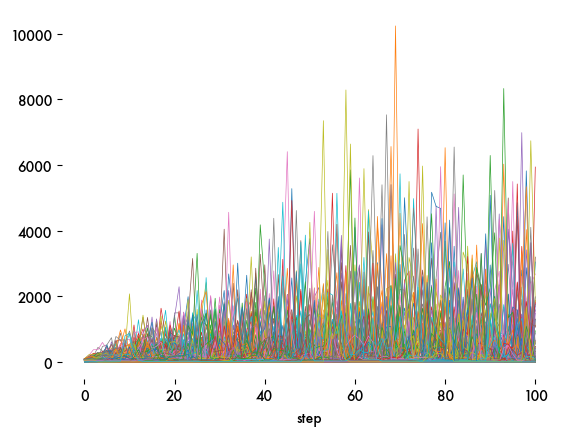

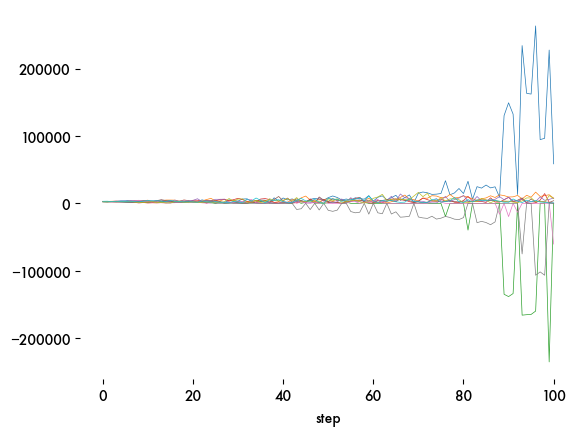

In [26]:
customer_wide = pd.pivot_table(customer_history, index = ['step'], values = ['balance'], columns = ['id'])
customer_wide.plot(linewidth=.5, legend=None)
sns.despine(left = True, bottom = True)
plt.show()

bank_wide = pd.pivot_table(bank_history, index = ['step'], values = ['reserves'], columns = ['id'])
bank_wide.plot(linewidth=.5, legend=None)
sns.despine(left = True, bottom = True)

These plots show the distribution of customer bank balances at the beginning of the simuation and the mean values at the end of the simulation steps.

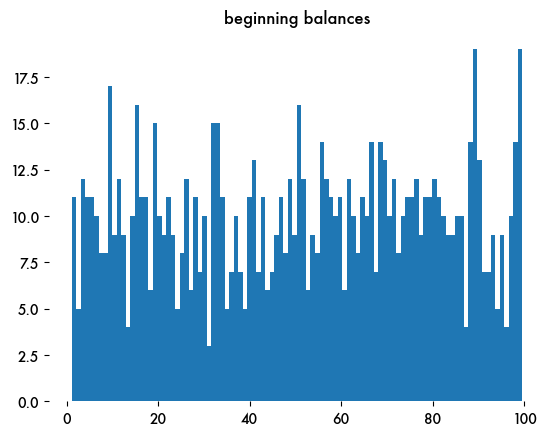

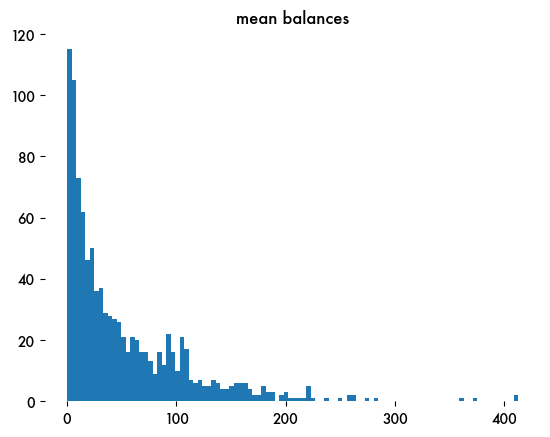

In [27]:
customer_history[customer_history['step'] == 0].hist('balance', bins = 100, grid=False)
plt.title('beginning balances')
sns.despine(left = True, bottom = True)
plt.show()

customer_history.groupby('id').mean().hist('balance', bins = 100, grid=False)
plt.title('mean balances')
sns.despine(left = True, bottom = True)

This final plot shows, for each bank, mean reserve and loan values.

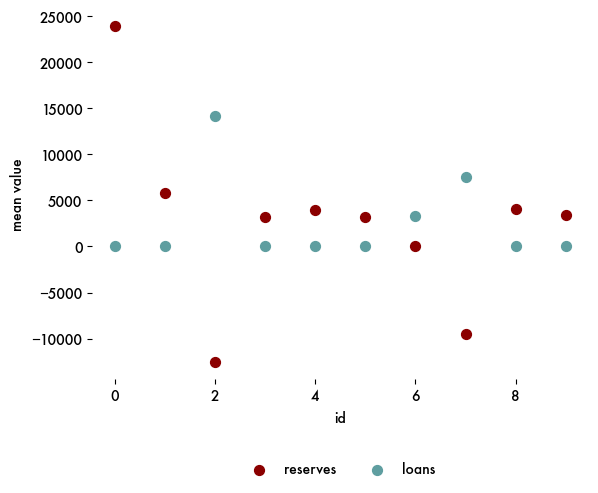

In [28]:
bank_means = bank_history[['id', 'reserves', 'loans']].groupby(by='id').mean()
bank_means = bank_means.reset_index()
ax = bank_means.plot.scatter(x = 'id', y = 'reserves', c = 'darkred', label = 'reserves', s = 50)
bank_means.plot.scatter(x = 'id', y = 'loans', c = 'cadetblue', label = 'loans', facecolors='none', s = 50, ax = ax)
plt.ylabel('mean value')
plt.legend(frameon=False, bbox_to_anchor=(0.5, -.3), loc='lower center', ncol=2)
sns.despine(left = True, bottom = True)